Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (65536, 28, 28) (65536,)
Test set (18000, 28, 28) (18000,)


sample_index:  [    95  91150  81556  97999 180334]
sample labels: [9 0 1 3 3]
sample_index:  [103511  38557 111127 116144 185466]
sample labels: [8 7 4 5 4]
sample_index:  [ 76426 121810 180011 129997  62529]
sample labels: [1 4 6 2 8]
sample_index:  [157128 145199 157026 193805  42873]
sample labels: [3 2 6 1 8]
sample_index:  [  1975  49305 104612   6184  37481]
sample labels: [4 6 3 8 7]


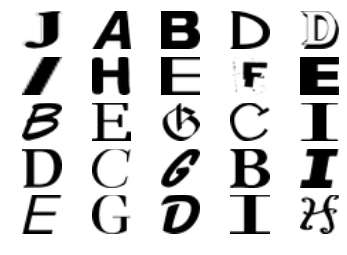

In [5]:

import matplotlib.pyplot as plt
import os
from IPython.display import display, Image
from scipy import ndimage

%matplotlib inline

def visual_confirmation(train_dataset, train_labels):
     fig, plt_axes_arr=plt.subplots(5, 5)
     for i in range(5):
         sample_index = np.random.choice(train_dataset.shape[0],5)
         print("sample_index: ", sample_index)
         print("sample labels:", train_labels[sample_index])
         for j,idx in enumerate(sample_index):
             plt_axes_arr[i,j].imshow(train_dataset[idx],cmap='Greys')
             plt_axes_arr[i,j].axis('off')
     plt.show()
visual_confirmation(train_dataset,train_labels)

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [6]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (65536, 784) (65536, 10)
Test set (18000, 784) (18000, 10)


In [7]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [8]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 179000
beta=0.005

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random valued following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  loss = loss + beta*tf.nn.l2_loss(weights, name=None)
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [9]:
num_steps = 801

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 30.614008
Training accuracy: 12.6%
Validation accuracy: 15.2%
Loss at step 100: 10.623415
Training accuracy: 71.8%
Validation accuracy: 71.9%
Loss at step 200: 6.312225
Training accuracy: 75.3%
Validation accuracy: 75.4%
Loss at step 300: 3.876953
Training accuracy: 77.5%
Validation accuracy: 77.6%
Loss at step 400: 2.495596
Training accuracy: 79.3%
Validation accuracy: 79.4%
Loss at step 500: 1.715370
Training accuracy: 80.8%
Validation accuracy: 80.9%
Loss at step 600: 1.273819
Training accuracy: 81.8%
Validation accuracy: 81.8%
Loss at step 700: 1.022390
Training accuracy: 82.5%
Validation accuracy: 82.4%
Loss at step 800: 0.878230
Training accuracy: 82.8%
Validation accuracy: 82.8%
Test accuracy: 89.3%


In [20]:
#With RELU
batch_size = 512
num_nodes=512
beta=0.0007

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
    
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
    
  weights_0 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_nodes],stddev=0.01))
  biases_0 = tf.Variable(tf.constant(0.1,shape=[512]))
  
    
  weights_1 = tf.Variable(
    tf.truncated_normal([num_nodes, num_labels]))
  biases_1 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits_train_0 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_0) + biases_0)
  logits_train_1 = tf.matmul(logits_train_0, weights_1) + biases_1
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train_1, tf_train_labels))
  loss = loss + beta*(tf.nn.l2_loss(weights_0, name=None) + tf.nn.l2_loss(weights_1, name=None))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.2).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train_1)

  valid_prediction = tf.nn.softmax(
    tf.matmul((tf.nn.relu(tf.matmul(tf_valid_dataset, weights_0) + biases_0)), weights_1) + biases_1)
  test_prediction = tf.nn.softmax(
    tf.matmul((tf.nn.relu(tf.matmul(tf_test_dataset, weights_0) + biases_0)), weights_1) + biases_1)

In [21]:
num_steps = 10003


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 5.811259
Minibatch accuracy: 9.0%
Validation accuracy: 40.6%
Minibatch loss at step 500: 2.050146
Minibatch accuracy: 85.7%
Validation accuracy: 85.7%
Minibatch loss at step 1000: 1.521429
Minibatch accuracy: 88.7%
Validation accuracy: 87.6%
Minibatch loss at step 1500: 1.157782
Minibatch accuracy: 89.8%
Validation accuracy: 88.3%
Minibatch loss at step 2000: 1.103972
Minibatch accuracy: 89.8%
Validation accuracy: 88.6%
Minibatch loss at step 2500: 0.948086
Minibatch accuracy: 91.6%
Validation accuracy: 89.1%
Minibatch loss at step 3000: 0.883045
Minibatch accuracy: 91.0%
Validation accuracy: 89.5%
Minibatch loss at step 3500: 0.787535
Minibatch accuracy: 91.6%
Validation accuracy: 89.6%
Minibatch loss at step 4000: 0.745144
Minibatch accuracy: 90.6%
Validation accuracy: 89.9%
Minibatch loss at step 4500: 0.667024
Minibatch accuracy: 93.6%
Validation accuracy: 90.0%
Minibatch loss at step 5000: 0.669701
Minibatch accuracy: 91.0%
Validation accuracy

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [12]:
#With RELU
batch_size = 16
num_nodes=16
beta=0.0007
train_subset = 16


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
    
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
    
  weights_0 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_nodes],stddev=0.01))
  biases_0 = tf.Variable(tf.constant(0.05,shape=[16]))
  
    
  weights_1 = tf.Variable(
    tf.truncated_normal([num_nodes, num_labels]))
  biases_1 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits_train_0 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_0) + biases_0)
  logits_train_1 = tf.matmul(logits_train_0, weights_1) + biases_1
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train_1, tf_train_labels))
  loss = loss + beta*(tf.nn.l2_loss(weights_0, name=None) + tf.nn.l2_loss(weights_1, name=None))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train_1)

  valid_prediction = tf.nn.softmax(
    tf.matmul((tf.nn.relu(tf.matmul(tf_valid_dataset, weights_0) + biases_0)), weights_1) + biases_1)
  test_prediction = tf.nn.softmax(
    tf.matmul((tf.nn.relu(tf.matmul(tf_test_dataset, weights_0) + biases_0)), weights_1) + biases_1)

In [ ]:
num_steps = 10


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 5 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [13]:
#With RELU
batch_size = 512
num_nodes=512

train_subset = 200000


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
    
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
    
  weights_0 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_nodes],stddev=0.001))
  biases_0 = tf.Variable(tf.constant(0.1,shape=[512]))
  
    
  weights_1 = tf.Variable(
    tf.truncated_normal([num_nodes, num_labels]))
  biases_1 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits_train_0 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_0) + biases_0)
  logits_train_1 = tf.nn.dropout(tf.matmul(logits_train_0, weights_1) + biases_1,0.5)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train_1, tf_train_labels))
  
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train_1)

  valid_prediction = tf.nn.softmax(
    tf.matmul((tf.nn.relu(tf.matmul(tf_valid_dataset, weights_0) + biases_0)), weights_1) + biases_1)
  test_prediction = tf.nn.softmax(
    tf.matmul((tf.nn.relu(tf.matmul(tf_test_dataset, weights_0) + biases_0)), weights_1) + biases_1)

In [ ]:
num_steps = 20501


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [ ]:
#With RELU
batch_size = 1024
num_nodes=1024

train_subset = 179000


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
    
    
  weights_0 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_nodes],stddev=0.001))
  biases_0 = tf.Variable(tf.constant(0.001,shape=[1024]))
    
  weights_1 = tf.Variable(
    tf.truncated_normal([num_nodes, num_nodes],stddev=0.001))
  biases_1 = tf.Variable(tf.constant(0.001,shape=[1024]))
  
    
  weights_2 = tf.Variable(
    tf.truncated_normal([num_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits_train_0 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_0) + biases_0)
  logits_train_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(logits_train_0, weights_1) + biases_1),0.5)
  logits_train_2 = tf.nn.dropout(tf.matmul(logits_train_1, weights_2) + biases_2,0.5)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train_2, tf_train_labels))
  
    
  # Optimizer.
  global_step = tf.Variable(0, trainable=False)
  starter_learning_rate = 0.01
  learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train_2)

  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_0) + biases_0), weights_1) + biases_1), weights_2) + biases_2)
    
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_0) + biases_0), weights_1) + biases_1), weights_2) + biases_2)


In [ ]:
num_steps = 20501


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

ADAM

In [ ]:
#With RELU
batch_size = 256
num_nodes=1024

train_subset = 179817


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
    
    
  weights_0 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_nodes],stddev=0.01))
  biases_0 = tf.Variable(tf.constant(0.001,shape=[1024]))
    
  weights_1 = tf.Variable(
    tf.truncated_normal([num_nodes, num_nodes],stddev=0.01))
  biases_1 = tf.Variable(tf.constant(0.001,shape=[1024]))
  
    
  weights_2 = tf.Variable(
    tf.truncated_normal([num_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits_train_0 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_0) + biases_0)
  logits_train_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(logits_train_0, weights_1) + biases_1),0.5)
  logits_train_2 = tf.nn.dropout(tf.matmul(logits_train_1, weights_2) + biases_2,0.5)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train_2, tf_train_labels))
  
    
  # Optimizer.
  global_step = tf.Variable(0, trainable=False)
  starter_learning_rate = 0.01
  learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           500, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  #optimizer=tf.train.AdamOptimizer().minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train_2)

  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_0) + biases_0), weights_1) + biases_1), weights_2) + biases_2)
    
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_0) + biases_0), weights_1) + biases_1), weights_2) + biases_2)


In [ ]:
num_steps = 10500


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

5 layer NN

In [48]:
#With RELU
batch_size = 512
num_nodes=1024
beta=0.0007
image_size=28

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
    
  weights_0 = tf.Variable(
    tf.truncated_normal([image_size * image_size, 1024],stddev=0.01))
  biases_0 = tf.Variable(tf.constant(0.07,shape=[1024]))
  
  
  weights_1 = tf.Variable(
    tf.truncated_normal([1024, 512],stddev=0.01))
  biases_1 = tf.Variable(tf.constant(0.07,shape=[512]))
  

 
  weights_2 = tf.Variable(
    tf.truncated_normal([512, 256],stddev=0.01))
  biases_2 = tf.Variable(tf.constant(0.07,shape=[256]))


  weights_3 = tf.Variable(
    tf.truncated_normal([256, 256],stddev=0.01))
  biases_3 = tf.Variable(tf.constant(0.1,shape=[256]))
    
    
  weights_4 = tf.Variable(
    tf.truncated_normal([256, num_labels]))
  biases_4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits_train_0 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_0) + biases_0)
  logits_train_1 = tf.nn.relu(tf.matmul(logits_train_0, weights_1) + biases_1)
  logits_train_2 = tf.nn.relu(tf.matmul(logits_train_1, weights_2) + biases_2)
  logits_train_3 = tf.nn.relu(tf.matmul(logits_train_2, weights_3) + biases_3)
  logits_train_4 = tf.matmul(logits_train_3, weights_4) + biases_4

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train_4, tf_train_labels))
  loss = loss + beta*(tf.nn.l2_loss(weights_0, name=None) + tf.nn.l2_loss(weights_1, name=None) 
                      + tf.nn.l2_loss(weights_2, name=None) + tf.nn.l2_loss(weights_3, name=None)
                     + tf.nn.l2_loss(weights_4, name=None))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.025).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train_4)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_0) + biases_0), weights_1) + biases_1), weights_2) + biases_2),weights_3) + biases_3), weights_4) + biases_4)
    
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_0) + biases_0), weights_1) + biases_1), weights_2) + biases_2),weights_3) + biases_3), weights_4) + biases_4)


In [49]:
num_steps = 35001


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.428053
Minibatch accuracy: 8.6%
Validation accuracy: 8.4%
Minibatch loss at step 500: 1.358825
Minibatch accuracy: 83.6%
Validation accuracy: 83.8%
Minibatch loss at step 1000: 1.216680
Minibatch accuracy: 84.0%
Validation accuracy: 85.3%
Minibatch loss at step 1500: 1.164320
Minibatch accuracy: 85.9%
Validation accuracy: 86.4%
Minibatch loss at step 2000: 1.095818
Minibatch accuracy: 87.9%
Validation accuracy: 87.5%
Minibatch loss at step 2500: 1.015997
Minibatch accuracy: 90.2%
Validation accuracy: 87.5%
Minibatch loss at step 3000: 1.013274
Minibatch accuracy: 90.0%
Validation accuracy: 88.7%
Minibatch loss at step 3500: 0.982419
Minibatch accuracy: 90.2%
Validation accuracy: 89.2%
Minibatch loss at step 4000: 1.019284
Minibatch accuracy: 89.1%
Validation accuracy: 89.3%
Minibatch loss at step 4500: 0.961202
Minibatch accuracy: 91.2%
Validation accuracy: 89.8%
Minibatch loss at step 5000: 0.948277
Minibatch accuracy: 92.0%
Validation accuracy: